#importing all libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

#Obtaining market data from twelvedata

In [2]:
api_key = 'ae33d65c666843ec9ea83892f64671b4'
symbol = 'BTC/USD'
interval = '30min'
order = 'asc'

start_date = '2022-03-10 00:00:00'
end_date = '2022-06-23 00:00:00'

api_url=f'https://api.twelvedata.com/time_series?apikey={api_key}&interval={interval}&symbol={symbol}&order={order}&start_date={start_date}&end_date={end_date}'

In [3]:
data = requests.get(api_url).json()
data_final = pd.DataFrame(data['values'])
data_final

,datetime,open,high,low,close
0,2022-03-10 07:30:00,39315.60156,39419.69141,39215.67188,39236.58984
1,2022-03-10 08:00:00,39248.55078,39248.55078,38868.89844,39053.23047
2,2022-03-10 08:30:00,39058.75000,39269.39844,39006.03125,39269.39844
3,2022-03-10 09:00:00,39235.32812,39297.55078,39104.00000,39169.82812
4,2022-03-10 09:30:00,39151.76172,39316.87109,39062.44141,39185.78125
...,...,...,...,...,...
4995,2022-06-22 22:00:00,19969.13086,20032.71094,19899.50977,19944.00977
4996,2022-06-22 22:30:00,19946.08008,20143.83008,19943.00000,20104.47070
4997,2022-06-22 23:00:00,20103.69922,20119.11914,20060.66016,20069.09961
4998,2022-06-22 23:30:00,20073.66016,20097.60938,19948.75977,19953.93945


#plotting the graph of bitcoin from the dataset

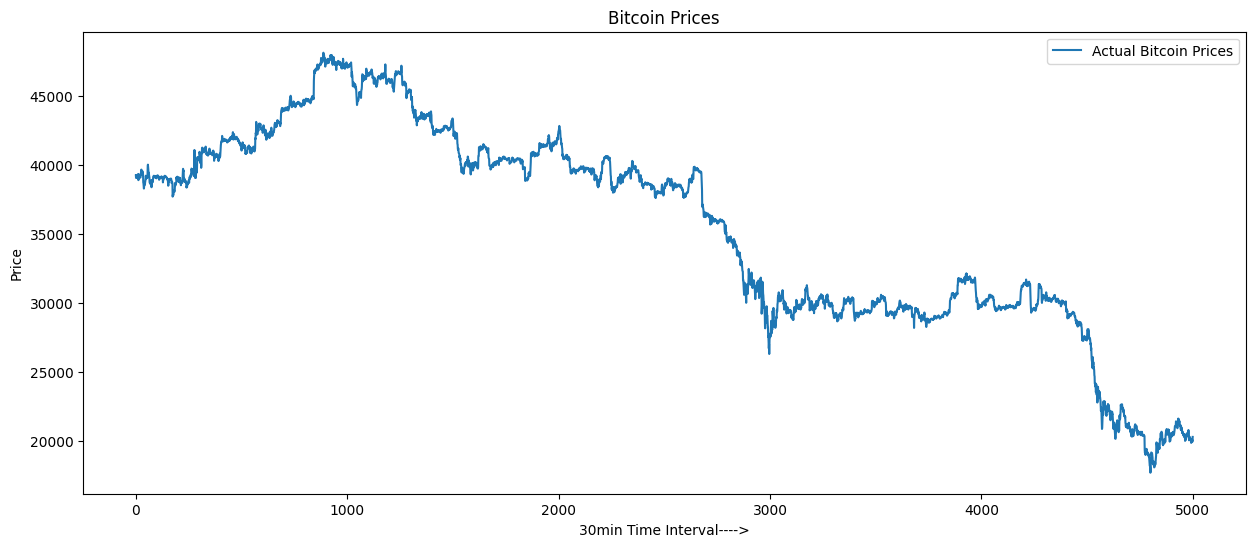

In [4]:
bitcoin_prices = pd.to_numeric(data_final['close'], errors = 'coerce').values

plt.figure(figsize=(15,6))
plt.plot(bitcoin_prices, label='Actual Bitcoin Prices')
plt.title('Bitcoin Prices')
plt.xlabel('30min Time Interval---->')
plt.ylabel('Price')
plt.legend()
plt.show()

#squishing our price data in the range [0, 1], this helps our optimization algorithm converge faster

In [5]:
#squishing data into the [0,1] price range
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data_final['close'].values.reshape(-1,1))

In [6]:
scaled_data

array([[0.70788167],
       [0.70185516],
       [0.70896   ],
       ...,
       [0.07789955],
       [0.07411455],
       [0.08525032]])

# Setting X_train and y_train

In [7]:
time_intervals_to_train = 24
prediction_interval = 12
x_train=[]
y_train=[]

In [8]:
for i in range(time_intervals_to_train, len(scaled_data)-prediction_interval):
  x_train.append(scaled_data[i - time_intervals_to_train: i, 0])
  y_train.append(scaled_data[i + prediction_interval, 0])

x_train = np.array(x_train)
y_train = np.array(y_train)

In [9]:
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

In [10]:
x_train.shape

(4964, 24, 1)

# Model creation and compilation

In [11]:
model = Sequential()
model.add(LSTM(128, return_sequences = True, input_shape =(x_train.shape[1],1), activation='relu'))
#to avoid overfitting, dropout layer has been used
model.add(Dropout(0.4))
model.add(LSTM(64, return_sequences = True, activation='relu'))
model.add(Dropout(0.3))
model.add(LSTM(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 128)           66560     
                                                                 
 dropout (Dropout)           (None, 24, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 24, 64)            49408     
                                                                 
 dropout_1 (Dropout)         (None, 24, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 3

In [13]:
model.compile(loss= 'mean_squared_error', optimizer='adam')

#Train the model on basis of training data


In [ ]:
model.fit(x_train, y_train, epochs = 10, batch_size=64)

Epoch 1/10


model has been trained

#Obtaining a new dataset to test the accuracy of our model

In [ ]:
test_start = '2022-06-23 00:00:00'
test_end = '2022-08-27 00:00:00'
test_api_url = f'https://api.twelvedata.com/time_series?apikey={api_key}&interval={interval}&symbol={symbol}&order={order}&start_date={test_start}&end_date={test_end}'
test_data = requests.get(test_api_url).json()
test_data_final = pd.DataFrame(test_data['values'])
test_data_final

In [ ]:
bitcoin_prices = pd.to_numeric(test_data_final['close'], errors = 'coerce').values
test_inputs = test_data_final['close'].values
test_inputs = test_inputs.reshape(-1,1)
model_inputs = scaler.fit_transform(test_inputs)
model_inputs

# Setting up x_test and y_test

In [ ]:
y_test = scaler.inverse_transform(model_inputs)

In [ ]:
x_test = []
for x in range(time_intervals_to_train, len(model_inputs)):
  x_test.append(model_inputs[x-time_intervals_to_train:x,0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
x_test.shape

#predicting prices of x_test using our model

In [ ]:
prediction_prices = model.predict(x_test)
prediction_prices = scaler.inverse_transform(prediction_prices)
prediction_prices

# Comparing predicted prices of x_test to actual values of y_test

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(bitcoin_prices, label='Actual Bitcoin Prices')
plt.plot(prediction_prices, label='Prediction Pries')
plt.title('Predicting Bitcoin Prices')
plt.xlabel('30 min Time Interval')
plt.ylabel('Price')
plt.legend()
plt.show()

# Predicting Bitcoin price after 6 hours

In [ ]:
last_data = model_inputs[len(model_inputs) - time_intervals_to_train:len(model_inputs)+1, 0]
last_data = np.array(last_data)
last_data

In [ ]:
last_data = np.reshape(last_data, (1, last_data.shape[0], 1))
last_data.shape

In [ ]:
prediction = model.predict(last_data)
prediction

In [ ]:
prediction = scaler.inverse_transform(prediction)
print("Bitcoin Price after 6 hours will be :")
print(prediction)